## Generate plate/continent RMS velocity figures.

In [1]:
from __future__ import print_function

from astropy_healpix import healpy
import pygplates
from ptt.utils import points_in_polygons
import math
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.signal import medfilt

import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True


#######################################################
# Define Input files
#######################################################

print(pygplates.__version__)

model_dir = 'Global_1000-0_Model_2017'

if model_dir == 'Global_1000-0_Model_2017':
    # Define the time snapshots.
    time_step = 5
    min_time = time_step
    max_time = 1000
    
    rotation_base_filenames = ['1000_0_rotfile_Merdith_et_al']

    # Models to plot.
    model_infos = [
        #(None, 'red', 'Not Optimized'),
        #('git_20200909_67baa20_run29', 'green', 'NR=1; TM=0.5; PV=0.5 (plate fragmentation)'),
        #('git_20200909_67baa20_run30', 'green', 'NR=1; TM=0.5; PV=0.5 (continent fragmentation)'),
        #('git_20200909_67baa20_run31', 'blue', 'NR=1; TM=0.5; PV=0.5 (without continent fragmentation)'),
        #('git_20210503_89d7a7e_run32', 'darkorange', 'NR=1; TM=0.5; PV=0'),
        ('git_20210503_89d7a7e_run33', 'darkorange', 'NR=0; TM=0; PV=1 (without individual contour weighting)'),
        #('git_20210503_89d7a7e_run34', 'blue', 'NR=0; TM=0; PV=1 (with continent fragmentation)'),
        ('git_20210503_89d7a7e_run35', 'magenta', 'NR=0; TM=0; PV=1 (with individual contour weighting)'),
        ('git_20210503_89d7a7e_run37', 'green', 'NR=1; TM=0.5; PV=0.5 (without individual contour weighting)'),
        ('git_20210503_89d7a7e_run36', 'blue', 'NR=1; TM=0.5; PV=0.5 (with individual contour weighting)'),
    ]
    
else:
    raise RuntimeError('Unknown model.')
    
input_dir = '../data/{0}'.format(model_dir)
output_dir = './{0}'.format(model_dir)

original_rotation_filenames = [os.path.join(input_dir, rotation_base_filename + '.rot')
        for rotation_base_filename in rotation_base_filenames]

if model_dir == 'Global_1000-0_Model_2017':
    topology_base_filenames = [
        '250-0_plate_boundaries_Merdith_et_al.gpml',
        '410-250_plate_boundaries_Merdith_et_al.gpml',
        '1000-410-Convergence_Merdith_et_al.gpml',
        '1000-410-Divergence_Merdith_et_al.gpml',
        '1000-410-Topologies_Merdith_et_al.gpml',
        '1000-410-Transforms_Merdith_et_al.gpml',
        'TopologyBuildingBlocks_Merdith_et_al.gpml',
    ]
    topology_filenames = [os.path.join(input_dir, base_filename)
            for base_filename in topology_base_filenames]
    
    continent_base_filenames = [
        'shapes_continents_Merdith_et_al.gpml'
    ]
    continent_filenames = [os.path.join(input_dir, base_filename)
            for base_filename in continent_base_filenames]
    
else:
    raise RuntimeError('Unknown model.')

# Plate features.
plate_features = [pygplates.FeatureCollection(file) for file in topology_filenames]

# Continent features.
continent_features = [pygplates.FeatureCollection(file) for file in continent_filenames]

# A list of times to sample.
times = range(min_time, max_time+1, time_step)

2.2.0.31


In [ ]:
def calculate_velocities(points, polygons, polygon_plate_ids, rotation_model, time):
            
    # Calculate velocity vectors at all sample points.
    velocity_vectors = []
    
    # Find the resolved plate polygon or reconstructed continental polygon (if any) containing each point.
    point_plate_ids = points_in_polygons.find_polygons(
            points,
            # The resolved plate polygon (or reconstructed continental polygon) geometries...
            polygons,
            # The plate ID of each resolved topology or reconstructed continent (this is what is returned by 'find_polygons')...
            polygon_plate_ids)

    # Dictionary of point lists indexed by plate ID (ie, each plate ID has a list of associated points).
    points_by_plate_id_dict = {}

    # Each point is contained by one polygon.
    for point_index, point_plate_id in enumerate(point_plate_ids):
        # If we're using topological plates, then if point is not in any resolved boundary then
        # it either fell in a tiny crack/gap or the topologies don't have global coverage.
        # If we're using continental polygons, then if point is not in any continental boundary then
        # it is on oceanic crust, and if it's in two polygons then they overlap (which can happen
        # when continental polygons are reconstructed) and we only see the first polygon encountered.
        # In all cases we ignore the point.
        if point_plate_id is not None:
            # Create dictionary entry (an empty list) if first time encountered plate ID.
            if point_plate_id not in points_by_plate_id_dict:
                points_by_plate_id_dict[point_plate_id] = []
            # Add point to dictionary entry.
            points_by_plate_id_dict[point_plate_id].append(points[point_index])

    # Calculate velocities for each plate ID (at all points associated with each plate ID).
    for plate_id in points_by_plate_id_dict.keys():
        # Get equivalent stage rotation from 'time' to 'time - 1'.
        equivalent_stage_rotation = rotation_model.get_rotation(time - 1, plate_id, time)

        points_with_plate_id = points_by_plate_id_dict[plate_id]
        velocity_vectors_with_plate_id = pygplates.calculate_velocities(
                points_with_plate_id,
                equivalent_stage_rotation,
                1.0, #interval
                # Units of cm/yr...
                velocity_units=pygplates.VelocityUnits.cms_per_yr)
        velocity_vectors.extend(velocity_vectors_with_plate_id)
    
    return velocity_vectors

In [ ]:
# HEALPix is a Hierarchical Equal Area isoLatitude Pixelization of a sphere.
# At base level (nSide=1) it has 12 pixels (of resolution ~58.6 degrees).
# Each subsequent level divides each pixel into 4 pixels (halving the resolution).
nSide = 2**5  # Resolution ~1.83 degrees (58.6 / 2^5)
longitudes, latitudes = healpy.pix2ang(nSide, np.arange(12 * nSide**2), lonlat=True)
sample_points = pygplates.MultiPointOnSphere(zip(latitudes, longitudes))

In [ ]:
velocity_models = []

for model_info in model_infos:
    model_name, _, _ = model_info

    if model_name is None:
        # Un-optimised rotation model.
        rotation_model = pygplates.RotationModel(original_rotation_filenames)
    else:
        # Optimised rotation model.
        optimised_rotation_filenames = [
                os.path.join(input_dir, 'optimisation', rotation_base_filename + '_{0}.rot'.format(model_name))
                    for rotation_base_filename in rotation_base_filenames]
        rotation_model = pygplates.RotationModel(optimised_rotation_filenames)

    rms_plate_velocities = []
    rms_continent_velocities = []
    
    # Reconstruct.
    for time in times:
        
        # Resolve the topological plate polygons for the current time.
        resolved_topologies = []
        pygplates.resolve_topologies(plate_features, rotation_model, resolved_topologies, time)

        # Get a list of resolved polygons and a list of their plate IDs.
        plate_polygons = []
        plate_polygon_plate_ids = []
        for resolved_topology in resolved_topologies:
            plate_polygons.append(resolved_topology.get_resolved_boundary())
            plate_polygon_plate_ids.append(resolved_topology.get_feature().get_reconstruction_plate_id())

        plate_velocity_vectors = calculate_velocities(
                sample_points, plate_polygons, plate_polygon_plate_ids, rotation_model, time)
        plate_velocity_magnitudes = [vec.get_magnitude() for vec in plate_velocity_vectors]

        rms_plate_velocities.append(np.sqrt(np.mean(np.array(plate_velocity_magnitudes)**2)))

        
        # Reconstruct the static continental polygons.
        reconstructed_feature_geometries = []
        pygplates.reconstruct(continent_features, rotation_model, reconstructed_feature_geometries, time)

        # Get a list of reconstructed continental polygons and a list of their plate IDs.
        continent_polygons = []
        continent_polygon_plate_ids = []
        for reconstructed_feature_geometry in reconstructed_feature_geometries:
            continent_polygons.append(reconstructed_feature_geometry.get_reconstructed_geometry())
            continent_polygon_plate_ids.append(reconstructed_feature_geometry.get_feature().get_reconstruction_plate_id())

        continent_velocity_vectors = calculate_velocities(
                sample_points, continent_polygons, continent_polygon_plate_ids, rotation_model, time)
        continent_velocity_magnitudes = [vec.get_magnitude() for vec in continent_velocity_vectors]

        rms_continent_velocities.append(np.sqrt(np.mean(np.array(continent_velocity_magnitudes)**2)))
        
    
    velocity_models.append((rms_plate_velocities, rms_continent_velocities))

In [ ]:
def plot_rms_velocities(medfilt_kernel_sizes):
    
    #
    # Plot figure(s) combining all models.
    #
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))
        
        fig.suptitle('Global plate vs continental RMS speeds', fontsize=16)

        for model_index in range(len(model_infos)):
            model_name, color, label = model_infos[model_index]
            
            rms_plate_velocities, rms_continent_velocities = velocity_models[model_index]
            
            # RMS plate velocities.
            plt.plot(
                times,
                medfilt(rms_plate_velocities, medfilt_kernel_size),
                color,
                dashes=(6,3), # Same colour but with dashes.
                label='Plate: {0}'.format(label))
            # RMS continent velocities.
            plt.plot(
                times,
                medfilt(rms_continent_velocities, medfilt_kernel_size),
                color,
                label='Continental: {0}'.format(label))

        plt.xlim([0, max_time])
        plt.ylim([0, 20])  # cms/yr
        plt.xticks(np.arange(0, max_time+1, 50))
        plt.yticks(np.arange(0, 20 + 1, 2))
        plt.ylabel('RMS speed (cm/yr)', fontsize=12)
        plt.xlabel('Age (Ma)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(model_dir, 'RMS_speeds_{0}My.pdf'.format(medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()
    
    
    #
    # Plot figure(s) with individual models.
    #
    for model_index in range(len(model_infos)):
        model_name, color, label = model_infos[model_index]
        
        rms_plate_velocities, rms_continent_velocities = velocity_models[model_index]
        
        fig = plt.figure(figsize=(9,6))
        fig.suptitle('Global plate vs continental RMS speeds', fontsize=16)
            
        # RMS plate velocities.
        plt.plot(
            times,
            medfilt(rms_plate_velocities, medfilt_kernel_size),
            'black',
            label='Plate')
        # RMS continent velocities.
        plt.plot(
            times,
            medfilt(rms_continent_velocities, medfilt_kernel_size),
            'red',
            label='Continental')

        plt.xlim([0, max_time])
        plt.ylim([0, 20])  # cms/yr
        plt.xticks(np.arange(0, max_time+1, 50))
        plt.yticks(np.arange(0, 20 + 1, 2))
        plt.ylabel('RMS speed (cm/yr)', fontsize=12)
        plt.xlabel('Age (Ma)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(
                    model_dir,
                    'RMS_speeds_{0}_{1}My.pdf'.format(
                            model_name if model_name else label,
                            medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()


#medfilt_kernel_sizes = [1, 5, 11]
medfilt_kernel_sizes = [1]

# Plot plate and continent RMS velocities for each model.
plot_rms_velocities(medfilt_kernel_sizes)

In [2]:
#
# Generate continental fragmentation index over time.
#
import sys
sys.path.insert(1, '../')
from continent_fragmentation import ContinentFragmentation

# Only need un-optimized rotation model since absolute plate motion shifts do not affect fragmentation.
# And so fragmentation index is the same for all optimised model runs.
original_rotation_filenames_rel_input_dir = [rotation_base_filename + '.rot'
        for rotation_base_filename in rotation_base_filenames]

# The grid spacing (in degrees) between points in the grid used for contouring/aggregrating blocks of continental polygons.
continental_fragmentation_point_spacing_degrees = 2.0

# Contour polygons smaller than this will be excluded when contouring/aggregrating blocks of continental polygons.
def continental_fragmentation_area_threshold_steradians(time):
    return 0.1

# Distance threshold to ensure small gaps between continents are ignored during contouring.
def continental_fragmentation_gap_threshold_radians(time):
    if time < 200:
        return math.radians(0.0)  # 1 degree is about 110 km
    elif time < 400:
        return math.radians(1.0)  # 1 degree is about 110 km
    else:
        return math.radians(2.0)  # 1 degree is about 110 km

continent_fragmentation = ContinentFragmentation(
        input_dir,
        original_rotation_filenames_rel_input_dir,
        continent_features,
        continental_fragmentation_point_spacing_degrees,
        continental_fragmentation_area_threshold_steradians,
        continental_fragmentation_gap_threshold_radians,
        times)

contoured_continents_over_time = [
        continent_fragmentation.get_contoured_continents(time)
        for time in times]

del continent_fragmentation  # Force the writing of debug GPML files.

time: 5
  0 perimeter/area: 0.0008353063008750091 km-1
  0 area: 160977560.68779692 km
  0 perimeter: 134465.57074200592 km
  1 perimeter/area: 0.0011068752432752864 km-1
  1 area: 17990064.891769614 km
  1 perimeter: 19912.75745361568 km
  2 perimeter/area: 0.0010984608175905399 km-1
  2 area: 22997683.602471214 km
  2 perimeter: 25262.054332659085 km
  3 perimeter/area: 0.0037718475274477158 km-1
  3 area: 6996332.234098591 km
  3 perimeter: 26389.098438387526 km
time: 10
  0 perimeter/area: 0.000966597509995248 km-1
  0 area: 168684252.90862682 km
  0 perimeter: 163049.77883688736 km
  1 perimeter/area: 0.0011350816209156106 km-1
  1 area: 18395021.552325282 km
  1 perimeter: 20879.85088039097 km
  2 perimeter/area: 0.0011107352235007358 km-1
  2 area: 22674969.783878706 km
  2 perimeter: 25185.887630768946 km
time: 15
  0 perimeter/area: 0.0008404912732627931 km-1
  0 area: 160279598.04977575 km
  0 perimeter: 134713.60344290468 km
  1 perimeter/area: 0.0011526130401231095 km-1
  1

time: 120
  0 perimeter/area: 0.0010402868218707278 km-1
  0 area: 41696112.409022644 km
  0 perimeter: 43375.91626234678 km
  1 perimeter/area: 0.0006489486916839025 km-1
  1 area: 150934682.27677062 km
  1 perimeter: 97948.86459323582 km
time: 125
  0 perimeter/area: 0.0007450508878347193 km-1
  0 area: 190283240.68888476 km
  0 perimeter: 141770.6974153212 km
time: 130
  0 perimeter/area: 0.0007597892557512612 km-1
  0 area: 189310390.51414675 km
  0 perimeter: 143836.00071472418 km
time: 135
  0 perimeter/area: 0.0007294155574708991 km-1
  0 area: 189274424.82689163 km
  0 perimeter: 138059.71010009095 km
time: 140
  0 perimeter/area: 0.0006426638414995973 km-1
  0 area: 192165325.4190876 km
  0 perimeter: 123497.70623685104 km
time: 145
  0 perimeter/area: 0.0006611361277920625 km-1
  0 area: 191071572.24843436 km
  0 perimeter: 126324.31940747122 km
time: 150
  0 perimeter/area: 0.0006916828062112192 km-1
  0 area: 188455645.36173695 km
  0 perimeter: 130351.52963015255 km
time: 

time: 320
  0 perimeter/area: 0.0005381876977927898 km-1
  0 area: 173483903.7332024 km
  0 perimeter: 93366.90275427816 km
  1 perimeter/area: 0.0022108994688412255 km-1
  1 area: 4275757.128269517 km
  1 perimeter: 9453.269163785159 km
time: 325
  0 perimeter/area: 0.0005081320548618685 km-1
  0 area: 175402508.36925307 km
  0 perimeter: 89127.63700559465 km
  1 perimeter/area: 0.002211804370697655 km-1
  1 area: 4274341.032600326 km
  1 perimeter: 9454.00617775773 km
time: 330
  0 perimeter/area: 0.0004790147299259935 km-1
  0 area: 174672492.52699798 km
  0 perimeter: 83670.69683332005 km
  1 perimeter/area: 0.002243334116399094 km-1
  1 area: 4072841.824376237 km
  1 perimeter: 9136.745015320339 km
time: 335
  0 perimeter/area: 0.0005383590989266855 km-1
  0 area: 176929884.4289024 km
  0 perimeter: 95251.8131543465 km
  1 perimeter/area: 0.0022916534998143013 km-1
  1 area: 4126742.130966723 km
  1 perimeter: 9457.063047261017 km
time: 340
  0 perimeter/area: 0.000470730259290375

time: 440
  0 perimeter/area: 0.0005840527909791695 km-1
  0 area: 114486170.31816326 km
  0 perimeter: 66865.96730283981 km
  1 perimeter/area: 0.001571358642446413 km-1
  1 area: 12304933.390147794 km
  1 perimeter: 19335.463427336177 km
  2 perimeter/area: 0.0008715873982281985 km-1
  2 area: 28638030.35274472 km
  2 perimeter: 24960.54636552895 km
  3 perimeter/area: 0.0011619627077308953 km-1
  3 area: 13159204.908403285 km
  3 perimeter: 15290.505366953968 km
time: 445
  0 perimeter/area: 0.0005673202448573062 km-1
  0 area: 115152002.45858845 km
  0 perimeter: 65328.06223061552 km
  1 perimeter/area: 0.0013409900287644717 km-1
  1 area: 10766732.325333226 km
  1 perimeter: 14438.080690647972 km
  2 perimeter/area: 0.0008905295316898425 km-1
  2 area: 29159548.40055897 km
  2 perimeter: 25967.438981437073 km
  3 perimeter/area: 0.001157138796755367 km-1
  3 area: 12479189.944515254 km
  3 perimeter: 14440.154836878055 km
time: 450
  0 perimeter/area: 0.0005653242707638092 km-1
  

time: 535
  0 perimeter/area: 0.0011938788944724163 km-1
  0 area: 13871897.041899404 km
  0 perimeter: 16561.36510461804 km
  1 perimeter/area: 0.0006739860751404803 km-1
  1 area: 110440334.33295022 km
  1 perimeter: 74435.24747426757 km
  2 perimeter/area: 0.0008699934775158581 km-1
  2 area: 27268282.12444808 km
  2 perimeter: 23723.2275913321 km
  3 perimeter/area: 0.001268666997690076 km-1
  3 area: 11981189.667023426 km
  3 perimeter: 15200.139923617971 km
time: 540
  0 perimeter/area: 0.0012113994283475794 km-1
  0 area: 14117857.985907674 km
  0 perimeter: 17102.365093620865 km
  1 perimeter/area: 0.0006687109104658317 km-1
  1 area: 109898182.04110178 km
  1 perimeter: 73490.11337124488 km
  2 perimeter/area: 0.0008468559006427628 km-1
  2 area: 27136020.982495714 km
  2 perimeter: 22980.299488992317 km
  3 perimeter/area: 0.0012659273884194045 km-1
  3 area: 11966013.643210538 km
  3 perimeter: 15148.104401140477 km
time: 545
  0 perimeter/area: 0.0016564186231914969 km-1
  

time: 625
  0 perimeter/area: 0.0014354887192941188 km-1
  0 area: 47016562.67649958 km
  0 perimeter: 67491.74534210005 km
  1 perimeter/area: 0.0007147603703048839 km-1
  1 area: 45124466.54545018 km
  1 perimeter: 32253.180417836324 km
  2 perimeter/area: 0.0012099816596254436 km-1
  2 area: 40640435.534902066 km
  2 perimeter: 49174.18163642165 km
  3 perimeter/area: 0.0015571911010460377 km-1
  3 area: 7095232.6153938575 km
  3 perimeter: 11048.633088542922 km
time: 630
  0 perimeter/area: 0.0015159988440960814 km-1
  0 area: 49572857.79266689 km
  0 perimeter: 75152.39511222242 km
  1 perimeter/area: 0.0007051761221504553 km-1
  1 area: 45313194.77482228 km
  1 perimeter: 31953.782973557452 km
  2 perimeter/area: 0.0013050775890197216 km-1
  2 area: 33472149.904711686 km
  2 perimeter: 43683.75269694783 km
  3 perimeter/area: 0.0015358937543950588 km-1
  3 area: 6790830.911799027 km
  3 perimeter: 10429.994784585026 km
  4 perimeter/area: 0.0017950106721150497 km-1
  4 area: 5846

time: 690
  0 perimeter/area: 0.0010268915436159964 km-1
  0 area: 94025062.24275512 km
  0 perimeter: 96553.54130505295 km
  1 perimeter/area: 0.0016193201027308447 km-1
  1 area: 25877918.33140793 km
  1 perimeter: 41904.6333708759 km
  2 perimeter/area: 0.0018838881872918927 km-1
  2 area: 5871371.98107431 km
  2 perimeter: 11061.00831834249 km
  3 perimeter/area: 0.0015896057903342 km-1
  3 area: 7064177.192608936 km
  3 perimeter: 11229.25696931796 km
  4 perimeter/area: 0.0020200789017430602 km-1
  4 area: 4502671.357431216 km
  4 perimeter: 9095.751410629586 km
  5 perimeter/area: 0.002484825672612871 km-1
  5 area: 4257131.438599562 km
  5 perimeter: 10578.229490319556 km
time: 695
  0 perimeter/area: 0.0010734043495532243 km-1
  0 area: 95834754.2595507 km
  0 perimeter: 102869.44206056613 km
  1 perimeter/area: 0.001590132007900652 km-1
  1 area: 25986706.830154594 km
  1 perimeter: 41322.294310559315 km
  2 perimeter/area: 0.0018582034579225303 km-1
  2 area: 5842104.8842348

time: 745
  0 perimeter/area: 0.0008971490737396618 km-1
  0 area: 81884750.94834231 km
  0 perimeter: 73462.8284667082 km
  1 perimeter/area: 0.0018859365236729938 km-1
  1 area: 5936166.575614901 km
  1 perimeter: 11195.233355558987 km
  2 perimeter/area: 0.0018449990105870095 km-1
  2 area: 15096091.057193225 km
  2 perimeter: 27852.273064252906 km
  3 perimeter/area: 0.0013878578974692187 km-1
  3 area: 23520886.931220163 km
  3 perimeter: 32643.64868297444 km
  4 perimeter/area: 0.002364395316181996 km-1
  4 area: 4763453.986876397 km
  4 perimeter: 11262.68829541901 km
  5 perimeter/area: 0.002454607769697228 km-1
  5 area: 4524125.13547591 km
  5 perimeter: 11104.952708621691 km
time: 750
  0 perimeter/area: 0.0008603823502058119 km-1
  0 area: 74841486.33968718 km
  0 perimeter: 64392.29390983621 km
  1 perimeter/area: 0.001915987752018445 km-1
  1 area: 5862831.113292408 km
  1 perimeter: 11233.112605220918 km
  2 perimeter/area: 0.0018127491594325535 km-1
  2 area: 15137785.2

time: 800
  0 perimeter/area: 0.0006845700727674896 km-1
  0 area: 82237968.73356314 km
  0 perimeter: 56297.65224018586 km
  1 perimeter/area: 0.0018652513038710612 km-1
  1 area: 13383990.497071335 km
  1 perimeter: 24964.505725660198 km
  2 perimeter/area: 0.0018167502324689666 km-1
  2 area: 5942166.4515219545 km
  2 perimeter: 10795.432282171805 km
  3 perimeter/area: 0.0013630191240549623 km-1
  3 area: 22757788.228895444 km
  3 perimeter: 31019.300577177404 km
  4 perimeter/area: 0.002219437059794914 km-1
  4 area: 8349064.596560158 km
  4 perimeter: 18530.22338022729 km
time: 805
  0 perimeter/area: 0.000681691155147643 km-1
  0 area: 82358279.00823864 km
  0 perimeter: 56142.91035309807 km
  1 perimeter/area: 0.002232689745767499 km-1
  1 area: 8180248.236696129 km
  1 perimeter: 18263.956355904113 km
  2 perimeter/area: 0.0018574477908180475 km-1
  2 area: 5934840.895719873 km
  2 perimeter: 11023.65711061148 km
  3 perimeter/area: 0.0018540062091001487 km-1
  3 area: 1341630

time: 890
  0 perimeter/area: 0.0007981125051666414 km-1
  0 area: 98235081.69897418 km
  0 perimeter: 78402.64715001796 km
  1 perimeter/area: 0.0015940548037812632 km-1
  1 area: 7527765.563791095 km
  1 perimeter: 11999.670858700365 km
  2 perimeter/area: 0.0015376270058727085 km-1
  2 area: 9488283.31895905 km
  2 perimeter: 14589.440670602968 km
  3 perimeter/area: 0.0024911428724395716 km-1
  3 area: 4356566.636987319 km
  3 perimeter: 10852.829926038996 km
time: 895
  0 perimeter/area: 0.0007970210146525311 km-1
  0 area: 98787151.45223586 km
  0 perimeter: 78735.43568509429 km
  1 perimeter/area: 0.0015819174924884098 km-1
  1 area: 7531639.987059678 km
  1 perimeter: 11914.433042654884 km
  2 perimeter/area: 0.0015217547200090744 km-1
  2 area: 9652949.168876989 km
  2 perimeter: 14689.42095974623 km
  3 perimeter/area: 0.0023613319022175406 km-1
  3 area: 4425581.98582585 km
  3 perimeter: 10450.267929009835 km
time: 900
  0 perimeter/area: 0.0007901503217609673 km-1
  0 area

time: 975
  0 perimeter/area: 0.000777107108376836 km-1
  0 area: 91957587.52900259 km
  0 perimeter: 71460.894937973 km
  1 perimeter/area: 0.0027538038943449826 km-1
  1 area: 5584191.559247013 km
  1 perimeter: 15377.768462622806 km
  2 perimeter/area: 0.0015387067518230488 km-1
  2 area: 9851967.332953852 km
  2 perimeter: 15159.288653956206 km
  3 perimeter/area: 0.0014606104255939793 km-1
  3 area: 8282891.443953949 km
  3 perimeter: 12098.077597102309 km
  4 perimeter/area: 0.0015437915648365643 km-1
  4 area: 7136022.382496236 km
  4 perimeter: 11016.53116058261 km
time: 980
  0 perimeter/area: 0.000753223329190074 km-1
  0 area: 92511726.5770857 km
  0 perimeter: 69681.99068151435 km
  1 perimeter/area: 0.002665920643925991 km-1
  1 area: 5584079.016857889 km
  1 perimeter: 14886.7115283554 km
  2 perimeter/area: 0.0015892327564169188 km-1
  2 area: 10074618.634538746 km
  2 perimeter: 16010.913942417266 km
  3 perimeter/area: 0.0014854628825012432 km-1
  3 area: 8331032.93373

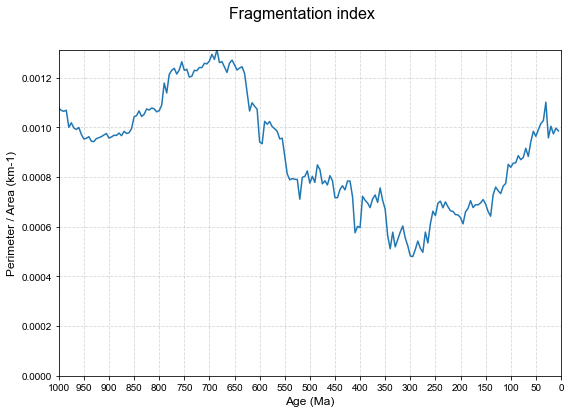

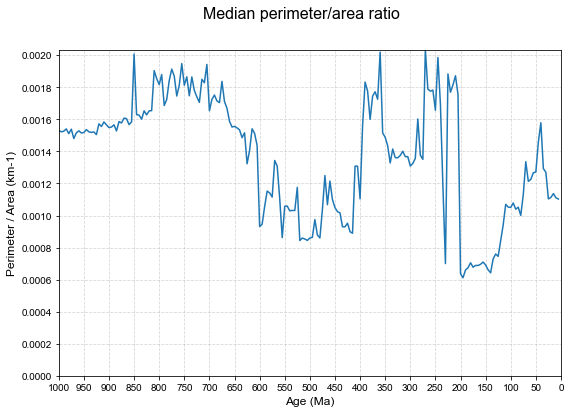

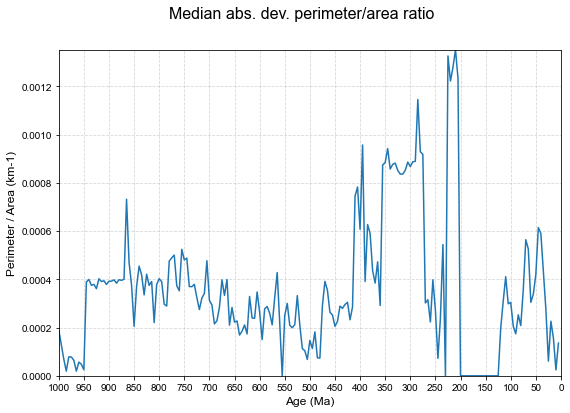

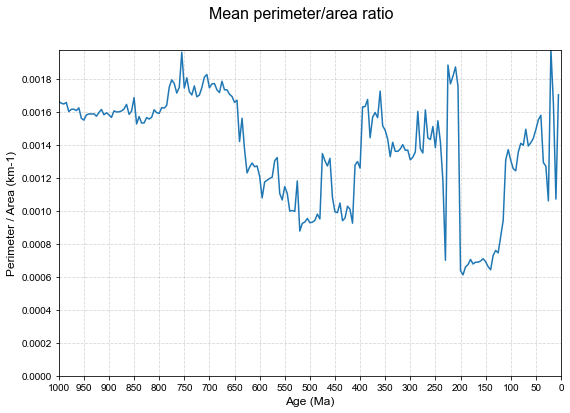

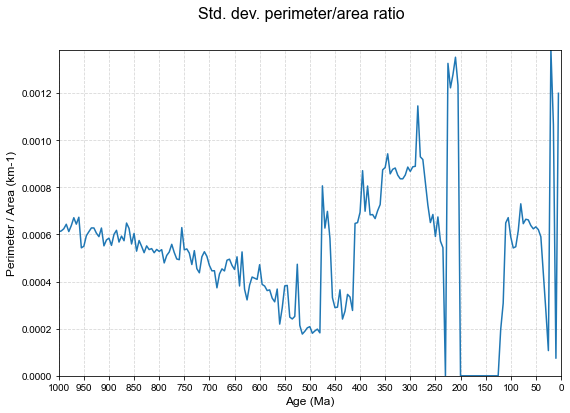

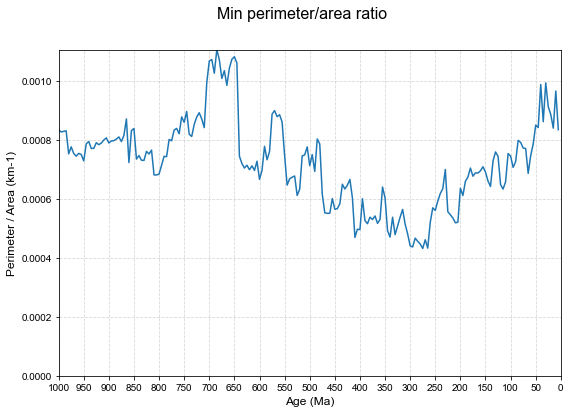

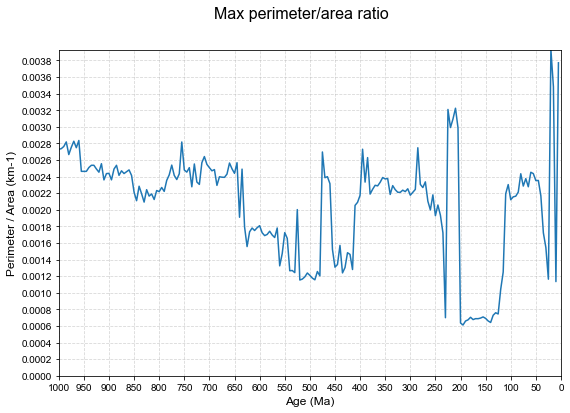

In [3]:
#
# Plot continental perimeter/area ratio over time.
#

def plot_perimeter_area_ratio(perimeter_area_ratios, plot_title, plot_base_filename, medfilt_kernel_sizes):
    
    #
    # Plot figure(s) combining all models.
    #
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))
        fig.suptitle(plot_title, fontsize=16)

        plt.plot(
            times,
            medfilt(perimeter_area_ratios, medfilt_kernel_size))

        ymin, ymax = np.min(perimeter_area_ratios), np.max(perimeter_area_ratios)
        plt.xlim([0, max_time])
        plt.ylim([0, ymax])
        plt.xticks(np.arange(0, max_time+1, 50))
        plt.yticks(np.arange(0, ymax, 0.0002))
        plt.ylabel('Perimeter / Area (km-1)', fontsize=12)
        plt.xlabel('Age (Ma)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        #plt.legend(fontsize=10)

        plt.savefig(
            #os.path.join(model_dir, '{}_{}My.pdf'.format(plot_base_filename, medfilt_kernel_size)),
            os.path.join(model_dir, plot_base_filename),
            format='pdf',
            dpi=600)

        plt.show()

#medfilt_kernel_sizes = [1, 5, 11]
medfilt_kernel_sizes = [1]

#
# Plot perimeter/area ratios.
#

# Fragmentation index.
plot_perimeter_area_ratio(
        [(sum(cc.get_perimeter() for cc in contoured_continents) /
             sum(cc.get_area() for cc in contoured_continents) /
             pygplates.Earth.equatorial_radius_in_kms)
                 for contoured_continents in contoured_continents_over_time],
        'Fragmentation index',
        'continent_fragmentation_index.pdf',
        medfilt_kernel_sizes)

# Median perimeter/area ratio.
plot_perimeter_area_ratio(
        [np.median([cc.get_perimeter_area_ratio() for cc in contoured_continents]) /
             pygplates.Earth.equatorial_radius_in_kms
             for contoured_continents in contoured_continents_over_time],
        'Median perimeter/area ratio',
        'continent_median_perimeter_area_ratio.pdf',
        medfilt_kernel_sizes)

# Median absolute deviation perimeter/area ratio.
median_abs_devs = []
for contoured_continents in contoured_continents_over_time:
    ratios = [cc.get_perimeter_area_ratio() for cc in contoured_continents]
    median_abs_devs.append(
        np.median(np.absolute(ratios - np.median(ratios))) / pygplates.Earth.equatorial_radius_in_kms)
plot_perimeter_area_ratio(
        median_abs_devs,
        'Median abs. dev. perimeter/area ratio',
        'continent_median_abs_dev_perimeter_area_ratio.pdf',
        medfilt_kernel_sizes)

# Mean perimeter/area ratio.
plot_perimeter_area_ratio(
        [np.mean([cc.get_perimeter_area_ratio() for cc in contoured_continents]) /
             pygplates.Earth.equatorial_radius_in_kms
             for contoured_continents in contoured_continents_over_time],
        'Mean perimeter/area ratio',
        'continent_mean_perimeter_area_ratio.pdf',
        medfilt_kernel_sizes)

# Std.dev. perimeter/area ratio.
plot_perimeter_area_ratio(
        [np.std([cc.get_perimeter_area_ratio() for cc in contoured_continents]) /
             pygplates.Earth.equatorial_radius_in_kms
             for contoured_continents in contoured_continents_over_time],
        'Std. dev. perimeter/area ratio',
        'continent_std_dev_perimeter_area_ratio.pdf',
        medfilt_kernel_sizes)

# Min perimeter/area ratio.
plot_perimeter_area_ratio(
        [np.min([cc.get_perimeter_area_ratio() for cc in contoured_continents]) /
             pygplates.Earth.equatorial_radius_in_kms
             for contoured_continents in contoured_continents_over_time],
        'Min perimeter/area ratio',
        'continent_min_perimeter_area_ratio.pdf',
        medfilt_kernel_sizes)

# Max perimeter/area ratio.
plot_perimeter_area_ratio(
        [np.max([cc.get_perimeter_area_ratio() for cc in contoured_continents]) /
             pygplates.Earth.equatorial_radius_in_kms
             for contoured_continents in contoured_continents_over_time],
        'Max perimeter/area ratio',
        'continent_max_perimeter_area_ratio.pdf',
        medfilt_kernel_sizes)